#  Lomb-Scargle periodogram (from astropy)

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

/tmp/ipykernel_8119/2080034654.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Misc

In [2]:
# inches -> cm conversion
cm=1/2.54

## Paths

In [3]:
from pathlib import Path

In [4]:
path_fig = Path('/home/lemasle/ASTRO/figures/var_class')
path_local_data = Path('/home/lemasle/ASTRO/projects/variable_stars_classification/data')

## Functions

In [5]:
def get_lc_data(path_local_data, star_ID):
    
    filename =  str(star_ID) + '.dat'
    file = path_local_data / filename
    lc = pd.read_csv(file, sep=' ', names=['JD', 'I', 'I_err'], dtype='float64')
    
    return lc    

In [6]:
def add_white_noise(lc, n):
    
    import random
    
    # create n random points of white noise

    rand_JD  = lc.JD.min() + np.random.sample(n) * (lc.JD.max()-lc.JD.min())
    rand_I  = lc.I.min() + (lc.I.max()-lc.I.min()) * np.random.sample(n)
    rand_I_err = np.random.sample(n) / 1000

    rand = pd.DataFrame(list(zip(rand_JD, rand_I, rand_I_err)), columns =['JD', 'I', 'I_err'])
    
    # append white noise 
    new_lc = pd.concat([lc, rand])
    new_lc.sort_values(['JD'], inplace=True)
    new_lc.reset_index(drop=True,inplace=True)
    
    return new_lc

In [7]:
def plot_raw_lc(lc, star_ID):

    # initialize the figure
    fig_raw_lc = plt.figure(figsize=(17.6*cm, 8.8*cm))
    ax1 = fig_raw_lc.add_subplot(111)
    
    ax1.set_xlabel(r'Julian day [day]')
    ax1.set_ylabel(r'I magnitude [mag]')
    ax1.tick_params(axis='both', left=True, right=True, bottom=True, top=True, direction='out')
    ax1.set_title('Observations as a function of time (Julian date)')

    ax1.scatter(lc.JD, lc.I, alpha=0.9, color='navy', s=0.1)

    # finalize the figure
    fig_raw_lc.tight_layout()
    filename = str(star_ID)+'.pdf'
    file = path_fig / str(filename)
    fig_raw_lc.savefig(file)    

In [8]:
def get_parameters_from_suspected_class(star_ID):

    # Since we already know the class of the example variable stars,
    # we restrict the parameter space to speed up the process

    if "CEP" in str(star_ID):
        print("The star is suspected to be a Cepheid")
        return (True, True, 10, 0.01, 0.33, 50)
 
    if "LYR" in str(star_ID):
        print("The star is suspected to be a RR Lyrae")
        return (True, True, 10, 0.6, 4, 50)

    else:
        print("Type unknown, skip")

In [9]:
def LombScarglePeriodogramm_astropy(lc, parameters):

    from astropy.timeseries import LombScargle
    
    # parameters provides parameters for the LS algorithm
    '''
    cd: center_data: Boolean
    fm: fit_mean: Boolean
    nf: nyquist_factor: Int64
    minf: minimum_frequency: float64
    maxf= maximum_frequency: float64
    spp: samples_per_peak: Int64    
    '''
    
    (cd, fm, nf, minf, maxf, spp) = parameters
    
    ls = LombScargle(t=lc.JD, y=lc.I, center_data = cd, fit_mean=fm)
    
    frequency, power = ls.autopower(
                                nyquist_factor=nf, 
                                minimum_frequency=minf,
                                maximum_frequency=maxf,
                                samples_per_peak=spp
                                )

    period_days = 1. / frequency
    period_hours = period_days * 24
    
    best_period = period_days[np.argmax(power)]

    #phase = (lc1.JD / best_period) % 1

    print("Best period: {0:.7f} days".format(best_period))
    print("Best period: {0:.4f} hours".format(24 * best_period))
    
    return ls, best_period, frequency, power

In [10]:
def LombScarglePeriodogramm_scipy(lc, parameters):

    import scipy.signal as signal

    # NOTE: The scipy LS algorithm requires ANGULAR frequencies as input
    
    # parameters provides parameters for the LS algorithm
    '''
    cd: center_data: Boolean
    fm: fit_mean: Boolean
    nf: nyquist_factor: Int64
    minf: minimum_frequency: float64
    maxf= maximum_frequency: float64
    spp: samples_per_peak: Int64    
    '''
    
    (cd, fm, nf, minf, maxf, spp) = parameters

    f = np.linspace(minf, maxf, 1000000)
    w = 2*np.pi * f
    p = 1/f
    
    power = signal.lombscargle(lc.JD, lc.I, w, precenter=cd, normalize=cd)
    
    period_days = p
    period_hours = period_days * 24
    
    best_period = period_days[np.argmax(power)]

    #phase = (lc1.JD / best_period) % 1

    print("Best period: {0:.7f} days".format(best_period))
    print("Best period: {0:.4f} hours".format(24 * best_period))
    
    return ls, best_period, period_days, power

In [11]:
def plot_PowerSpectrum_astropy(frequency, power, parameters, star_ID, path_fig):
    
    # initialize the figure
    fig = plt.figure(figsize=(17.6*cm, 8.8*cm))
    ax = fig.add_subplot(111)

    ax.set_ylabel(r'Lomb-Scargle power')
    ax.tick_params(axis='both', left=True, right=True, bottom=True, top=True, direction='out')

    (cd, fm, nf, minf, maxf, spp) = parameters
    xmin = 0.07
    xmax = 1.05 * maxf

    period_days = 1. / frequency
    best_period = period_days[np.argmax(power)]
    best_frequency = 1. / best_period

    ax.set_xlim(xmin,xmax)
    ax.set_ylim(-0.1, 5.1)
    ax.plot(frequency, power, rasterized=True, color='navy')

    ax.axvline(x = best_frequency, color = 'blue', linestyle = 'dashed', lw=0.75, label = 'Best frequency')
    ax.legend(loc = 'upper right')
    ax.annotate("Best period: {0:.7f} days".format(best_period), xy=(0.64, 0.77), xycoords='figure fraction')

    # finalize the figure
    fig.tight_layout()
    filename = 'PowerSpectrum_' + str(star_ID)+'.pdf'
    file = path_fig / str(filename)
    fig.savefig(file)  

In [12]:
def plot_PowerSpectrum_scipy(period, power, parameters, star_ID, path_fig):
    
    # initialize the figure
    fig = plt.figure(figsize=(17.6*cm, 8.8*cm))
    ax = fig.add_subplot(111)

    ax.set_ylabel(r'Lomb-Scargle power (scipy)')
    ax.tick_params(axis='both', left=True, right=True, bottom=True, top=True, direction='out')

    (cd, fm, nf, minf, maxf, spp) = parameters
    xmin = period.min()
    xtemp = period.max()
    
    best_period = period[np.argmax(power)]
    best_frequency = 1. / best_period

    # adjust x-axis limits
    if best_period<10 and xtemp>2: # value adjusted to apply only to long period Cepheids
        xmax = 0.1 * xtemp
    elif best_period<30  and xtemp>2:
        xmax = 0.33 * xtemp
    else: xmax = xtemp
    ax.set_xlim(xmin,xmax)
    # y-axis limits not set

    ax.plot(period, power, rasterized=True, color='navy')

    ax.axvline(x = best_period, color = 'red', linestyle = 'dashed', zorder=10, lw=0.75, label = 'Best period')
    ax.legend(loc = 'upper right')
    ax.annotate("Best period: {0:.7f} days".format(best_period), xy=(0.64, 0.77), xycoords='figure fraction')

    # finalize the figure
    fig.tight_layout()
    filename = 'PowerSpectrum_' + str(star_ID)+'.pdf'
    file = path_fig / str(filename)
    fig.savefig(file)  

In [13]:
def get_phased_lc(lc, best_period):
    
    lc['phase'] = (lc.JD / best_period) % 1

    return lc

In [14]:
def plot_phased_lc(lc, star_ID, path_fig):
    
    # initialize the figure
    fig = plt.figure(figsize=(17.6*cm, 8.8*cm))
    ax = fig.add_subplot(111)
    
    ax.set_xlabel(r'Phase')    
    ax.set_ylabel(r'I magnitude [mag]')
    ax.tick_params(axis='both', left=True, right=True, bottom=True, top=True, direction='out')

    ax.set_xlim(0,2)
    ax.set_ylim(lc.I.min()-0.1, lc.I.max()+0.2)
    ax.scatter(lc.phase, lc.I, color='navy', s=1)
    ax.scatter(lc.phase+1, lc.I, color='navy', s=1)

    ax.annotate(str(star_ID), xy=(0.2, 0.85), xycoords='figure fraction')
    ax.annotate("P={0:.7f} days".format(best_period), xy=(0.5, 0.85), xycoords='figure fraction')

    plt.show()
    
    # finalize the figure
    fig.tight_layout()
    filename = 'Phased_lightcurve_' + str(star_ID)+'.pdf'
    file = path_fig / str(filename)
    fig.savefig(file)      

OGLE-IV I-band lightcurves from a fundamental mode Cepheid and two RRab-type RR Lyrae in the Large Magellanic Cloud.

# Lomb-Scargle: Astropy

OGLE-LMC-CEP-0091
The star is suspected to be a Cepheid
Best period: 3.5989925 days
Best period: 86.3758 hours


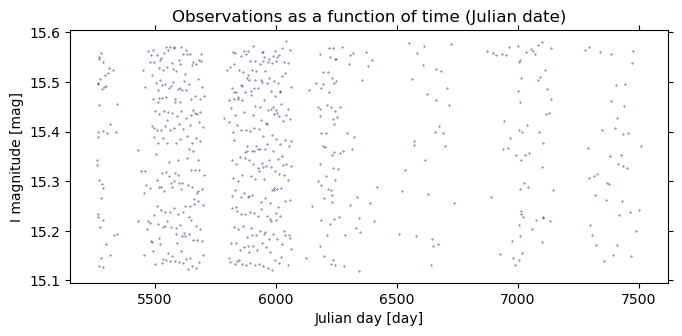

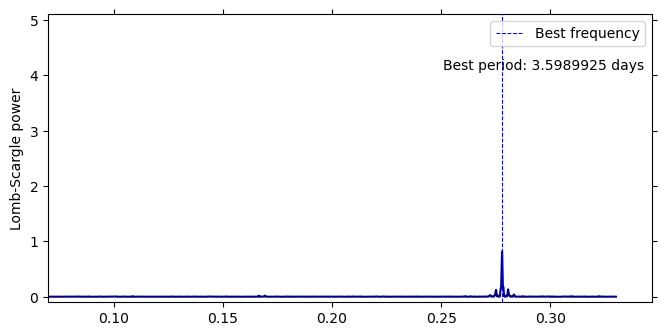

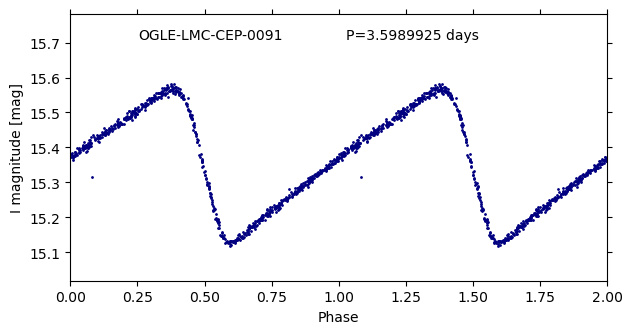

OGLE-LMC-RRLYR-03735
The star is suspected to be a RR Lyrae
Best period: 0.7590943 days
Best period: 18.2183 hours


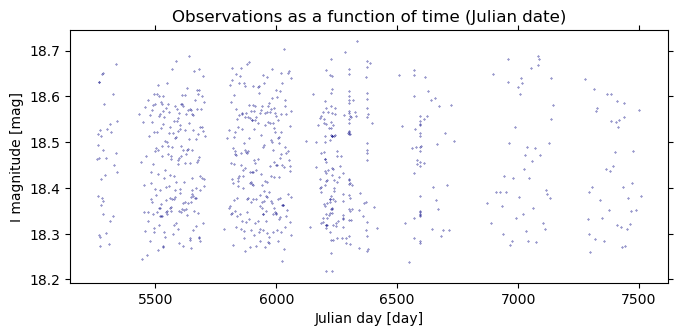

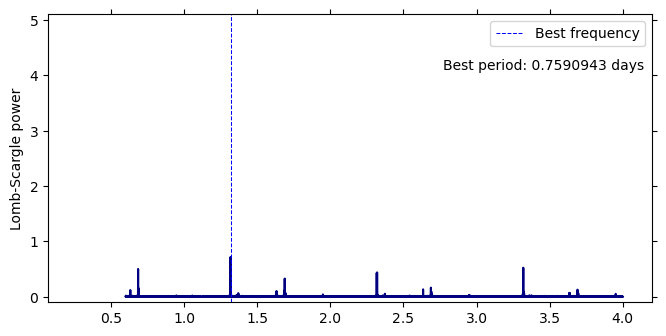

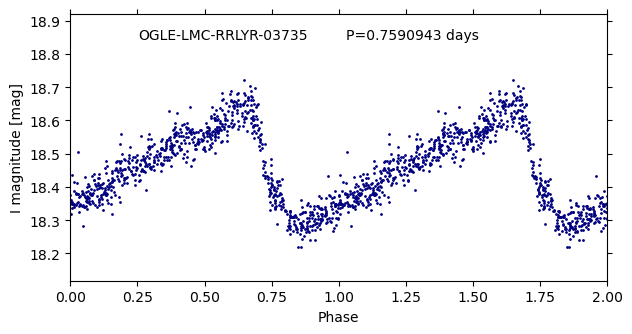

OGLE-LMC-RRLYR-36679
The star is suspected to be a RR Lyrae
Best period: 0.6337514 days
Best period: 15.2100 hours


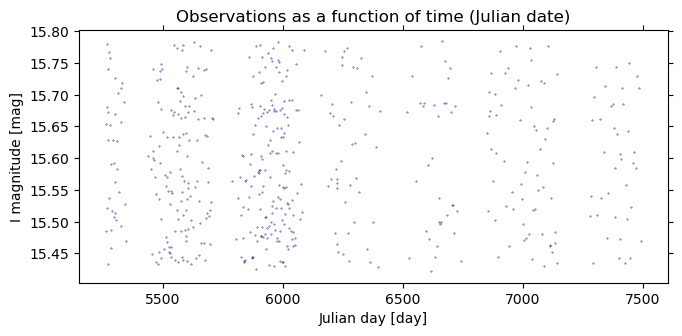

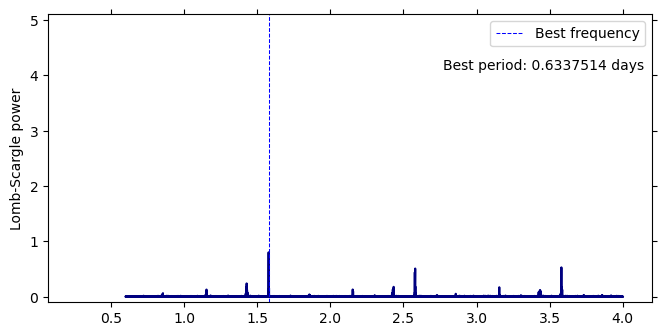

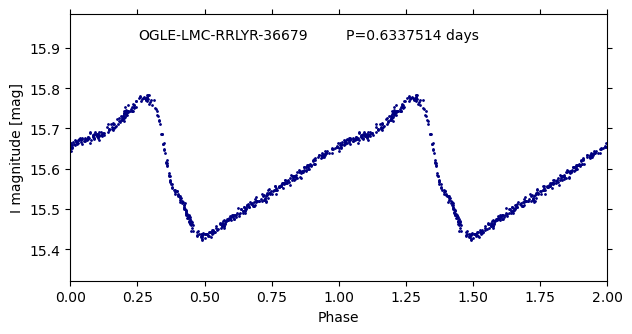

In [15]:
list_ID = ['OGLE-LMC-CEP-0091', 'OGLE-LMC-RRLYR-03735', 'OGLE-LMC-RRLYR-36679']

for star_ID in list_ID:
    print(star_ID)
    parameters = get_parameters_from_suspected_class(star_ID)
    lc = get_lc_data(path_local_data, star_ID)
    plot_raw_lc(lc, star_ID)
    ls, best_period, frequency, power = LombScarglePeriodogramm_astropy(lc, parameters)
    plot_PowerSpectrum_astropy(frequency, power, parameters, star_ID, path_fig)
    get_phased_lc(lc, best_period)
    plot_phased_lc(lc, star_ID, path_fig)

# Lomb-Scargle: Scipy

OGLE-LMC-CEP-0091
The star is suspected to be a Cepheid
Best period: 3.5990245 days
Best period: 86.3766 hours


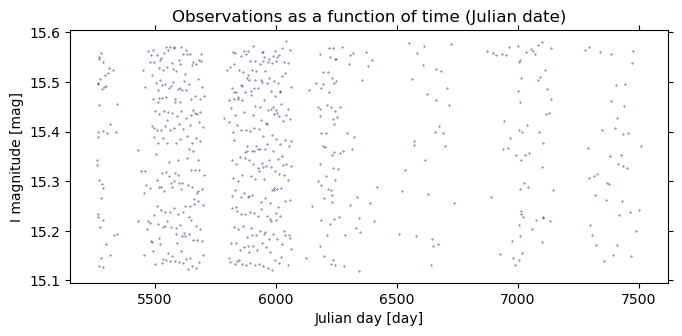

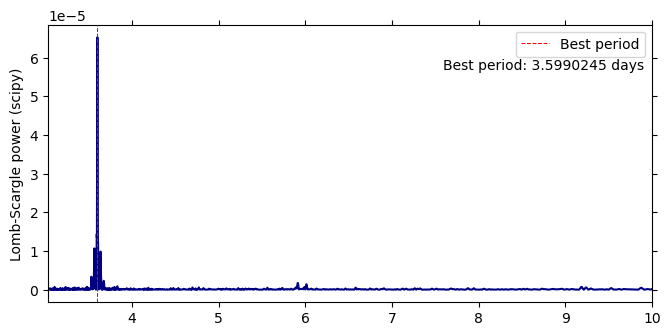

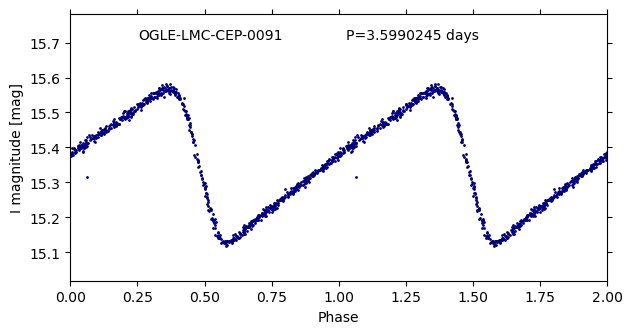

OGLE-LMC-RRLYR-03735
The star is suspected to be a RR Lyrae
Best period: 0.7590940 days
Best period: 18.2183 hours


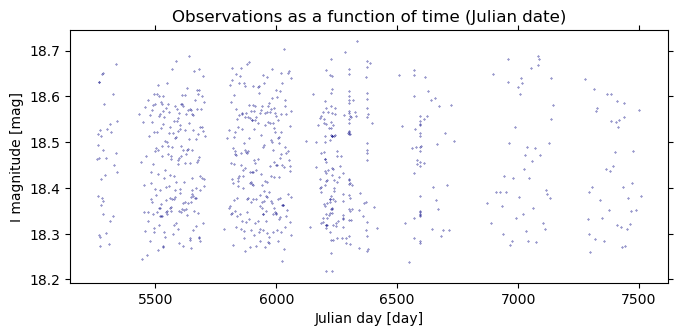

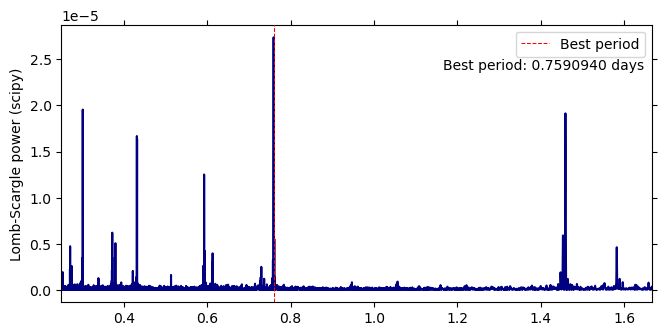

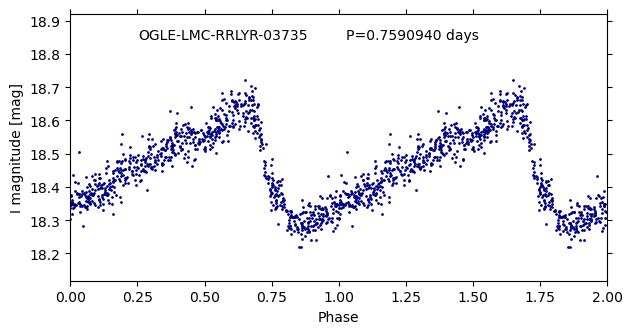

OGLE-LMC-RRLYR-36679
The star is suspected to be a RR Lyrae
Best period: 0.6337528 days
Best period: 15.2101 hours


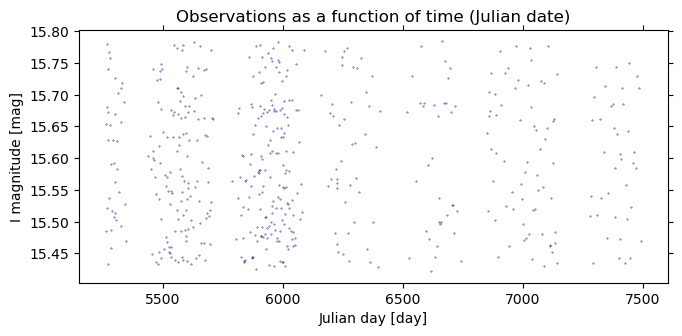

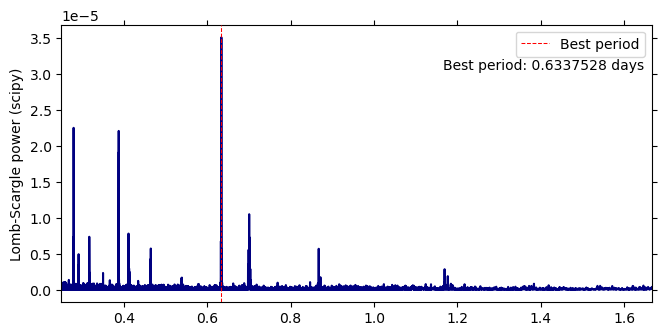

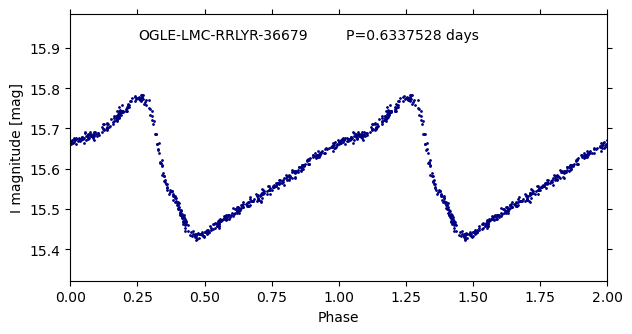

In [16]:
list_ID = ['OGLE-LMC-CEP-0091', 'OGLE-LMC-RRLYR-03735', 'OGLE-LMC-RRLYR-36679']

for star_ID in list_ID:
    print(star_ID)
    parameters = get_parameters_from_suspected_class(star_ID)
    lc = get_lc_data(path_local_data, star_ID)
    plot_raw_lc(lc, star_ID)
    ls, best_period, frequency, power = LombScarglePeriodogramm_scipy(lc, parameters)
    plot_PowerSpectrum_scipy(frequency, power, parameters, star_ID, path_fig)
    get_phased_lc(lc, best_period)
    plot_phased_lc(lc, star_ID, path_fig)